# RNN for Human Activity Recognition - 2D Pose Input

This experiment aims to determine the level of accuracy attainable in Human activity recognition using a 2D body pose dataset and an LSTM RNN. This involves classifying the type of movement amongst six categories:
- JUMPING,
- JUMPING_JACKS,
- BOXING,
- WAVING_2HANDS,
- WAVING_1HAND,
- CLAPPING_HANDS.

The motivation behind this experiment is to determine if:

- 2D pose has comparable accuracy to 3D pose for activity estimation using an LSTM RNN, allowing the use of RGB only cameras for pose estimation, as opposed to RGBD or a large motion capture dataset.

- 2D pose has comparable accuracy to using raw RGB images for activity estimation using an LSTM RNN. This is based on the assumption that limiting the input feature vector may help to deal with a limited dataset (citation required)

- Verify the concept for use in future works involving behaviour prediction from motion in 2D images


## Dataset overview

The dataset is comprised of pose estimations, made using the software OpenPose (https://github.com/CMU-Perceptual-Computing-Lab/openpose's) on a subset of the Berkeley Multimodal Human Action Database (MHAD) dataset http://tele-immersion.citris-uc.org/berkeley_mhad.

This dataset is composed of 12 subjects doing the 6 listed actions for 5 repetitions, filmed from 4 angles, repeated 5 times each.  
In total, there are 1438 videos (2 were missing) made up of 211200 individual frames.

The below image is an example of the 4 camera views during the 'boxing' action for subject 1

![alt text](boxing_all_views .gif.png "Title")

The input for the LSTM is the 2D position of 18 joints across a timeseries of frames numbering n_steps (window-width), with an associated class label for the frame series.  
A single frame's input is stored as:

[  295.914,161.579,307.693,203.413,281.546,203.368,274.997,251.562,267.194,  
   293.253,337.619,204.669,347.958,255.443,341.541,295.866,286.81,289.393,  
   297.196,355.832,297.22,405.371,321.967,291.959,327.143,358.408,328.528,  
   411.922,294.546,156.42,305.002,156.418,0,0,318.083,161.632  ]

For the following experiment, very little preprocessing has been done to the dataset.  
In some cases, multiple people were detected in each frame, in which only the first detection was used.

The data has not been normalised with regards to subject position in the frame, motion across frame (if any), size of the subject, speed of action etc. It is essentially the raw 2D position of each joint viewed from a stationary camera.  
In many cases, individual joints were not located and a position of [0.0,0.0] was given for that joint

A summary of the dataset used for input is:

 - 211200 individual images 
 - n_steps = 33 frames (~=1.5s at 22Hz)
 - images with noisy pose detection (detection of >=2 people) = 5132  
 - training_split = 0.8




## Training and Results below: 


In [1]:
# All Includes
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
from random import randint

import os

In [2]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "data/HAR_pose_activities/database/"

X_train_path = DATASET_PATH + "x_train.txt"
X_test_path = DATASET_PATH + "x_test.txt"

y_train_path = DATASET_PATH + "y_train.txt"
y_test_path = DATASET_PATH + "y_test.txt"

n_steps = 33 # 33 timesteps per series

## Preparing dataset:

In [3]:

# Load "X" (the neural network's training and testing inputs)

def load_X(X_path):
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ #np.transpose(np.array(X_), (1, 2, 0))

# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)


## Additional Parameters:

Here are some core parameter definitions for the training. 

The whole neural network's structure could be summarised by enumerating those parameters and the fact an LSTM is used. 

In [4]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # num testing series
#n_steps = len(X_train[0])  # num timesteps per series
n_input = len(X_train[0][0])  # num input parameters per timestep

# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 600  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")




(X shape, y shape, every X's mean, every X's standard deviation)
((1197, 33, 36), (1197, 1), 250.95729, 125.17004)

The dataset has not been preprocessed, is not normalised etc


## Utility functions for training:

In [5]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    #print(_X.shape)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



## Build the network:

In [6]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



## Train the network:

In [7]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
        #print temp_ys
        
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


Training iter #1500:   Batch Loss = 5.376561, Accuracy = 0.111333332956
PERFORMANCE ON TEST SET: Batch Loss = 3.70396280289, Accuracy = 0.203842937946
Training iter #30000:   Batch Loss = 2.913618, Accuracy = 0.0540000014007
PERFORMANCE ON TEST SET: Batch Loss = 3.01928901672, Accuracy = 0.25898078084
Training iter #60000:   Batch Loss = 3.258708, Accuracy = 0.0166666675359
PERFORMANCE ON TEST SET: Batch Loss = 2.92236757278, Accuracy = 0.316624909639
Training iter #90000:   Batch Loss = 2.628126, Accuracy = 0.57800000906
PERFORMANCE ON TEST SET: Batch Loss = 2.8362224102, Accuracy = 0.313283205032
Training iter #120000:   Batch Loss = 2.712450, Accuracy = 0.289999991655
PERFORMANCE ON TEST SET: Batch Loss = 2.73598742485, Accuracy = 0.371762752533
Training iter #150000:   Batch Loss = 3.040203, Accuracy = 0.12866666913
PERFORMANCE ON TEST SET: Batch Loss = 2.55611920357, Accuracy = 0.442773610353
Training iter #180000:   Batch Loss = 2.266284, Accuracy = 0.611333310604
PERFORMANCE ON 

Training iter #1620000:   Batch Loss = 1.350785, Accuracy = 0.80666667223
PERFORMANCE ON TEST SET: Batch Loss = 1.32979035378, Accuracy = 0.82957392931
Training iter #1650000:   Batch Loss = 1.580064, Accuracy = 0.709999978542
PERFORMANCE ON TEST SET: Batch Loss = 1.36880588531, Accuracy = 0.803675830364
Training iter #1680000:   Batch Loss = 1.153096, Accuracy = 0.888000011444
PERFORMANCE ON TEST SET: Batch Loss = 1.30579149723, Accuracy = 0.833751022816
Training iter #1710000:   Batch Loss = 1.355557, Accuracy = 0.805333316326
PERFORMANCE ON TEST SET: Batch Loss = 1.31021749973, Accuracy = 0.841269850731
Training iter #1740000:   Batch Loss = 1.698990, Accuracy = 0.670000016689
PERFORMANCE ON TEST SET: Batch Loss = 1.33684790134, Accuracy = 0.821219742298
Training iter #1770000:   Batch Loss = 1.200604, Accuracy = 0.898000001907
PERFORMANCE ON TEST SET: Batch Loss = 1.44305348396, Accuracy = 0.77192980051
Training iter #1800000:   Batch Loss = 1.489656, Accuracy = 0.754000008106
PERF

## Results:



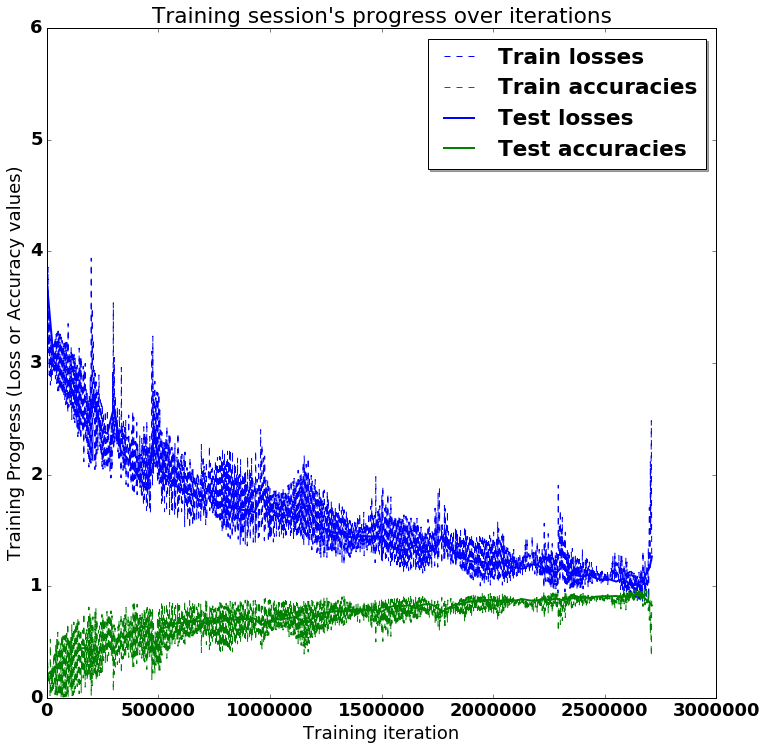

Testing Accuracy: 82.7067673206%

Precision: 84.1000820594%
Recall: 82.7067669173%
f1_score: 82.8250569287%

Confusion Matrix:
Created using test set of 1197 datapoints, normalised to % of each class in the test dataset


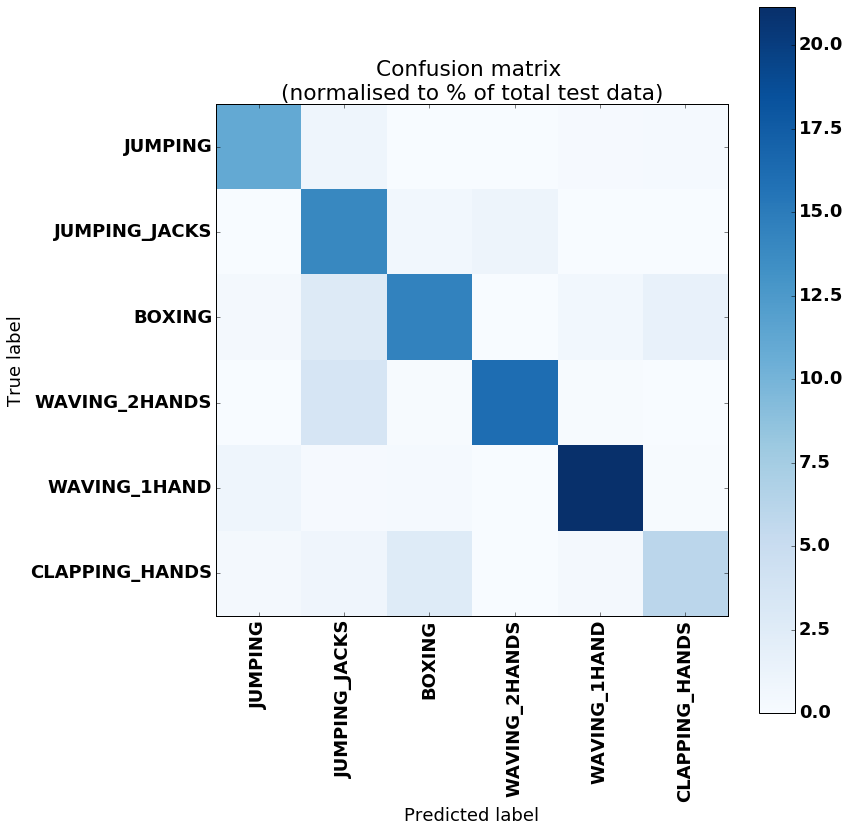

In [8]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", linewidth=2.0, label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [9]:
sess.close()

## Conclusion

Comment  on accuracy overall

Accuracy of each class and expectations
    eg clapping hands vs boxing

Applicability to wider dataset

Future works


## Future Works

Possibility to extend into a bidirectional-LSTM   (https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs)

Use on subtler activity classes and perhaps `normal vs abnormal` activity


## References

The dataset can be found at http://tele-immersion.citris-uc.org/berkeley_mhad released under the BSD-2 license
>Copyright (c) 2013, Regents of the University of California All rights reserved.

The network used in this experiment is based on the following, available under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE). :
> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition



In [10]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md

[NbConvertApp] Converting notebook LSTM.ipynb to markdown
[NbConvertApp] Writing 25351 bytes to LSTM.md
